Comparar o desempenho de redes Peceptron Simples, MLP e ELM utilizando os datasets Breast Cancer e Vertebral Column.

50 rodadas independentes.

As figuras de mérito serão:
* Acurácia no treino e teste na forma de boxplot;
* Matrizes de confusão no treinamento e teste.

In [1]:
# Bibliotecas
import numpy as np
import pandas as pd

In [2]:
NUM_ROUNDS = 50

## Definição dos modelos

A distância euclidiana será utilizada nos dois modelos.

In [3]:
class Perceptron:
  def __init__(self, input_dim, output_dim, lr):
    self.weights = np.random.uniform(-1, 1, (output_dim, input_dim)).astype(np.float32)
    self.bias = np.random.uniform(-1, 1, output_dim).astype(np.float32)
    self.lr = lr

  def fit(self, X, y, epochs=50):
    X = X.astype(np.float32)
    unique_labels, y_mapped = np.unique(y, return_inverse=True)

    for _ in range(epochs):
      outputs = X @ self.weights.T + self.bias
      preds = np.argmax(outputs, axis=1)

      misclassified = preds != y_mapped
      for i in np.where(misclassified)[0]:
        x_i = X[i]
        y_true = y_mapped[i]
        y_pred = preds[i]

        self.weights[y_true] += self.lr * x_i
        self.bias[y_true] += self.lr
        self.weights[y_pred] -= self.lr * x_i
        self.bias[y_pred] -= self.lr

  def predict(self, X):
    X = X.astype(np.float32)
    scores = X @ self.weights.T + self.bias
    return np.argmax(scores, axis=1)

In [4]:
def tanh(x):
  return np.tanh(x)

def tanh_derivative(x):
  return 1 - np.tanh(x)**2

def to_one_hot(y, num_classes, target_range=(-1, 1)):
  y_one_hot = np.full((len(y), num_classes), target_range[0])
  y_one_hot[np.arange(len(y)), y] = target_range[1]
  return y_one_hot

In [5]:
class MLP:
  def __init__(self, input_dim, hidden_dim, output_dim, lr):
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.w1 = np.random.uniform(-1, 1, (input_dim, hidden_dim)).astype(np.float32)
    self.b1 = np.random.uniform(-1, 1, (1, hidden_dim)).astype(np.float32)
    self.w2 = np.random.uniform(-1, 1, (hidden_dim, output_dim)).astype(np.float32)
    self.b2 = np.random.uniform(-1, 1, (1, output_dim)).astype(np.float32)
    self.lr = lr


  def fit(self, X, y, epochs=50):
    X = X.astype(np.float64)
    y_target = to_one_hot(y, self.output_dim, target_range=(-1, 1))

    for _ in range(epochs):
      z1 = X @ self.w1 + self.b1
      a1 = tanh(z1)
      z2 = a1 @ self.w2 + self.b2
      a2 = tanh(z2)

      # Backward
      error = a2 - y_target
      d_z2 = error * tanh_derivative(z2)

      error_hidden = d_z2 @ self.w2.T
      d_z1 = error_hidden * tanh_derivative(z1)

      self.w2 -= self.lr * (a1.T @ d_z2)
      self.b2 -= self.lr * np.sum(d_z2, axis=0, keepdims=True)
      self.w1 -= self.lr * (X.T @ d_z1)
      self.b1 -= self.lr * np.sum(d_z1, axis=0, keepdims=True)

  def predict(self, X):
    X = X.astype(np.float64)
    z1 = X @ self.w1 + self.b1
    a1 = tanh(z1)
    z2 = a1 @ self.w2 + self.b2
    a2 = tanh(z2)
    return np.argmax(a2, axis=1)

In [6]:
class ELM:
  def __init__(self, input_dim, hidden_dim, output_dim):
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.input_weights = np.random.uniform(-1, 1, (input_dim, hidden_dim))
    self.bias = np.random.uniform(-1, 1, (1, hidden_dim))
    self.output_weights = None

  def fit(self, X, y):
    X = X.astype(np.float64)
    y_one_hot = to_one_hot(y, self.output_dim)

    H = tanh(X @ self.input_weights + self.bias)

    H_inv = np.linalg.pinv(H)
    self.output_weights = H_inv @ y_one_hot

  def predict(self, X):
    X = X.astype(np.float64)
    H = tanh(X @ self.input_weights + self.bias)
    predictions = H @ self.output_weights
    return np.argmax(predictions, axis=1)

# Datasets

Instalando a biblioteca do UCI Datasets para baixar os datasets.

In [7]:
!pip install ucimlrepo --quiet

In [8]:
from ucimlrepo import fetch_ucirepo

In [9]:
def train_test_split(X, y, test_size=0.2, random_state=None):
  if random_state is not None:
      np.random.seed(random_state)
  n_samples = len(X)
  shuffled_indices = np.random.permutation(n_samples)
  test_size = int(n_samples * test_size)
  test_indices = shuffled_indices[:test_size]
  train_indices = shuffled_indices[test_size:]
  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]
  return X_train, X_test, y_train, y_test

In [10]:
def label_encoder(y):
  unique_labels = np.unique(y)
  label_to_int = {label: i for i, label in enumerate(unique_labels)}
  encoded = np.array([label_to_int[label] for label in y])
  return encoded, unique_labels

In [11]:
def normalize_features(X):
    min_vals = X.min(axis=0)
    max_vals = X.max(axis=0)
    # Evita divisão por zero caso uma coluna tenha valor constante
    range_vals = np.where(max_vals - min_vals == 0, 1, max_vals - min_vals)
    return 2 * ((X - min_vals) / range_vals) - 1

# Métricas

In [12]:
def accuracy(y_true, y_pred):
  return np.sum(y_true == y_pred) / len(y_true)

In [13]:
def confusion_matrix(y_true, y_pred, num_classes):
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for true_idx, pred_idx in zip(y_true, y_pred):
        conf_matrix[true_idx, pred_idx] += 1
    return conf_matrix

## Plotagem

In [14]:
import matplotlib.pyplot as plt
import seaborn as sn

In [15]:
def plot_accuracy_boxplots(results, dataset_name):
  model_names = list(results.keys())
  train_accuracies = [results[name]['acc_train'] for name in model_names]
  test_accuracies = [results[name]['acc_test'] for name in model_names]

  fig, ax = plt.subplots(figsize=(8, 6))
  x = np.arange(len(model_names))
  width = 0.35

  bplot1 = ax.boxplot(train_accuracies,
                      positions=x - width/2,
                      widths=width,
                      patch_artist=True,
                      boxprops=dict(facecolor="lightblue"),
                      medianprops=dict(color="blue"))

  bplot2 = ax.boxplot(test_accuracies,
                      positions=x + width/2,
                      widths=width,
                      patch_artist=True,
                      boxprops=dict(facecolor="lightgreen"),
                      medianprops=dict(color="darkgreen"))

  ax.set_ylabel('Acurácia', fontsize=12)
  ax.set_title(f'Distribuição das Acurácias de Treino e Teste - {dataset_name} ({NUM_ROUNDS} Rodadas)', fontsize=14)
  ax.set_xticks(x)
  ax.set_xticklabels(model_names, rotation=10, ha="right")
  ax.legend([bplot1["boxes"][0], bplot2["boxes"][0]], ['Treino', 'Teste'], loc='lower right')
  ax.set_ylim(top=1.02)
  ax.grid(True, linestyle='--', alpha=0.6)

  plt.tight_layout()
  plt.show()

In [16]:
def plot_confusion_matrices(matrices, class_names, dataset_name):
    model_names = list(matrices.keys())
    fig, axes = plt.subplots(len(model_names), 2, figsize=(10, 5 * len(model_names)))
    fig.suptitle(f'Matrizes de Confusão Médias - {dataset_name}', fontsize=16, y=1.02)

    for i, model in enumerate(model_names):
        sn.heatmap(matrices[model]['train'], annot=True, fmt=".0f", cmap='Blues', ax=axes[i, 0],
                   xticklabels=class_names, yticklabels=class_names, cbar=False)
        axes[i, 0].set_title(f'{model} (Treino)')
        axes[i, 0].set_xlabel('Predito')
        axes[i, 0].set_ylabel('Verdadeiro')

        sn.heatmap(matrices[model]['test'], annot=True, fmt=".0f", cmap='Greens', ax=axes[i, 1],
                   xticklabels=class_names, yticklabels=class_names, cbar=False)
        axes[i, 1].set_title(f'{model} (Teste)')
        axes[i, 1].set_xlabel('Predito')
        axes[i, 1].set_ylabel('Verdadeiro')

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# Função genérica

Os resultados tendem a variar muito com o tamanho do passo e o número de neurônios na camada oculta para cada modelo. Por isso, tive que adicionar mais parâmetros. Não é o ideal, mas nesse caso, dá pro gasto.

In [17]:
def evaluate_models_on_dataset(X, y, perceptron_lr, mlp_lr, mlp_hidden_size, elm_hidden_size):
  print("Dimensão dos dados de entrada:", X.shape)

  y_encoded, class_labels = label_encoder(y)
  num_classes = len(class_labels)
  input_dim = X.shape[1]

  results = {
      "Perceptron": {"acc_train": [], "acc_test": []},
      "MLP": {"acc_train": [], "acc_test": []},
      "ELM": {"acc_train": [], "acc_test": []},
  }
  conf_matrices = {
      "Perceptron": {"train": np.zeros((num_classes, num_classes)), "test": np.zeros((num_classes, num_classes))},
      "MLP": {"train": np.zeros((num_classes, num_classes)), "test": np.zeros((num_classes, num_classes))},
      "ELM": {"train": np.zeros((num_classes, num_classes)), "test": np.zeros((num_classes, num_classes))},
  }

  for i in range(NUM_ROUNDS):
    print(f"Executando Rodada {i+1}/{NUM_ROUNDS}...", end='\r')
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=i)

    models = {
        "Perceptron": Perceptron(input_dim, num_classes, perceptron_lr),
        "MLP": MLP(input_dim, mlp_hidden_size, num_classes, mlp_lr),
        "ELM": ELM(input_dim, elm_hidden_size, num_classes)
    }

    for name, model in models.items():
      if hasattr(model, 'fit'):
          model.fit(X_train, y_train)

      y_pred_train = model.predict(X_train)
      acc_train = accuracy(y_train, y_pred_train)
      results[name]["acc_train"].append(acc_train)
      conf_matrices[name]["train"] += confusion_matrix(y_train, y_pred_train, num_classes)

      y_pred_test = model.predict(X_test)
      acc_test = accuracy(y_test, y_pred_test)
      results[name]["acc_test"].append(acc_test)
      conf_matrices[name]["test"] += confusion_matrix(y_test, y_pred_test, num_classes)

  summary_data = {}
  for name in models.keys():
      mean_train = np.mean(results[name]['acc_train'])
      std_train = np.std(results[name]['acc_train'])
      mean_test = np.mean(results[name]['acc_test'])
      std_test = np.std(results[name]['acc_test'])
      summary_data[name] = {
          'Acurácia Média (Treino)': f'{mean_train:.4f} ± {std_train:.4f}',
          'Acurácia Média (Teste)': f'{mean_test:.4f} ± {std_test:.4f}',
      }
  summary_df = pd.DataFrame.from_dict(summary_data, orient='index')

  avg_conf_matrices = {name: {
      "train": conf_matrices[name]["train"] / NUM_ROUNDS,
      "test": conf_matrices[name]["test"] / NUM_ROUNDS
      } for name in models.keys()}

  return summary_df, results, avg_conf_matrices, class_labels

# Teste com Breast Cancer

In [18]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets.values.ravel()

In [19]:
X = 2 * ((X - X.min()) / (X.max() - X.min())) - 1

In [20]:
summary_bc, results_bc, conf_matrices_bc, labels_bc = evaluate_models_on_dataset(
    X.values, y, perceptron_lr=0.01, mlp_lr=0.001, mlp_hidden_size=10, elm_hidden_size=10)

Dimensão dos dados de entrada: (569, 30)


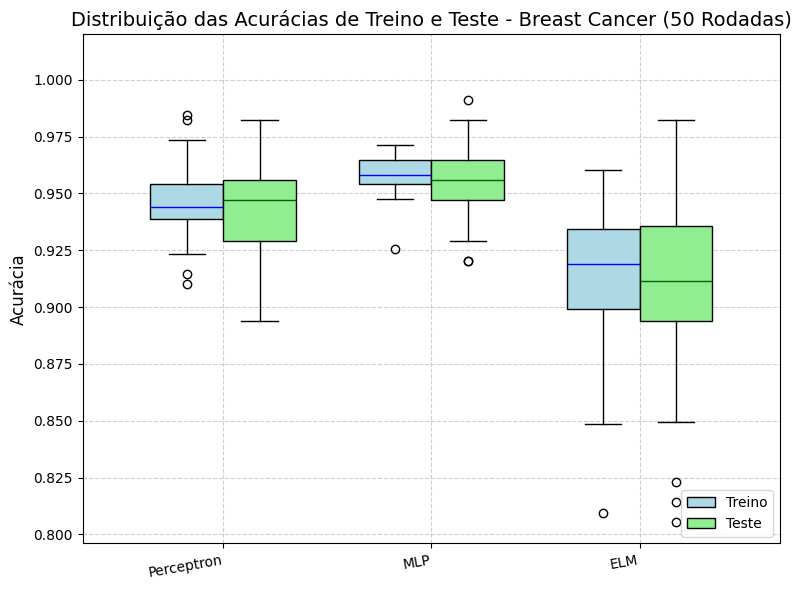

In [21]:
plot_accuracy_boxplots(results_bc, "Breast Cancer")

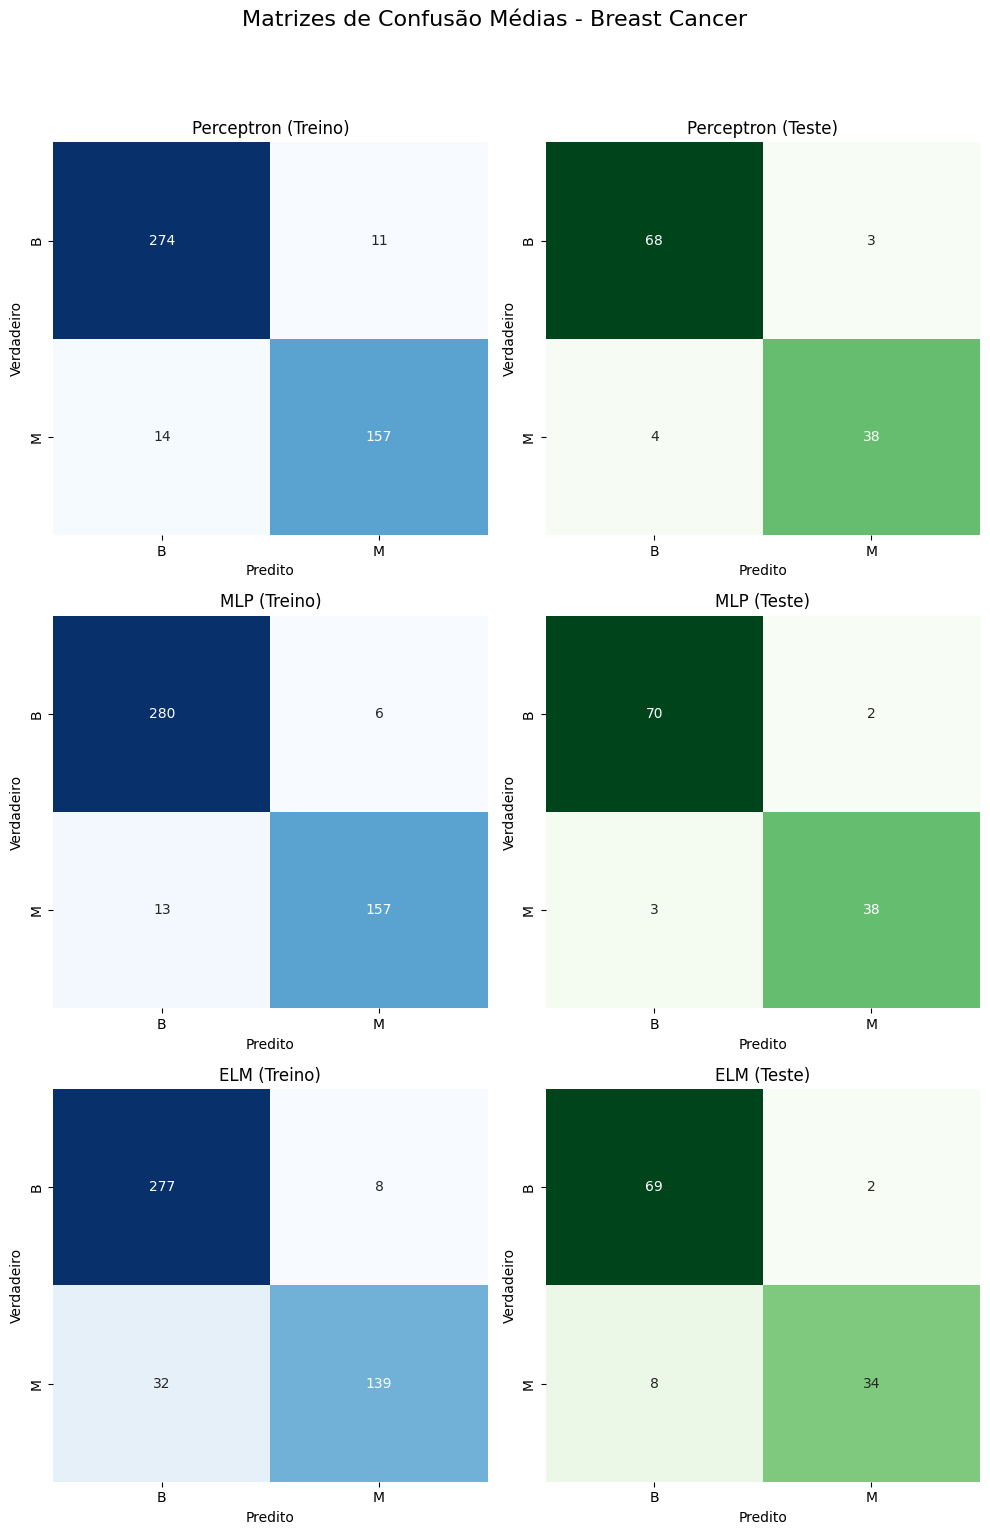

In [22]:
plot_confusion_matrices(conf_matrices_bc, labels_bc, "Breast Cancer")

# Teste com Vertebral Column

In [23]:
vertebral_column = fetch_ucirepo(id=212)

X = vertebral_column.data.features
y = vertebral_column.data.targets.values.ravel()

In [24]:
X = 2 * ((X - X.min()) / (X.max() - X.min())) - 1

In [32]:
summary_vc, results_vc, conf_matrices_vc, labels_vc = evaluate_models_on_dataset(
    X.values, y, perceptron_lr=0.01, mlp_lr=0.001, mlp_hidden_size=12, elm_hidden_size=22)

Dimensão dos dados de entrada: (310, 6)


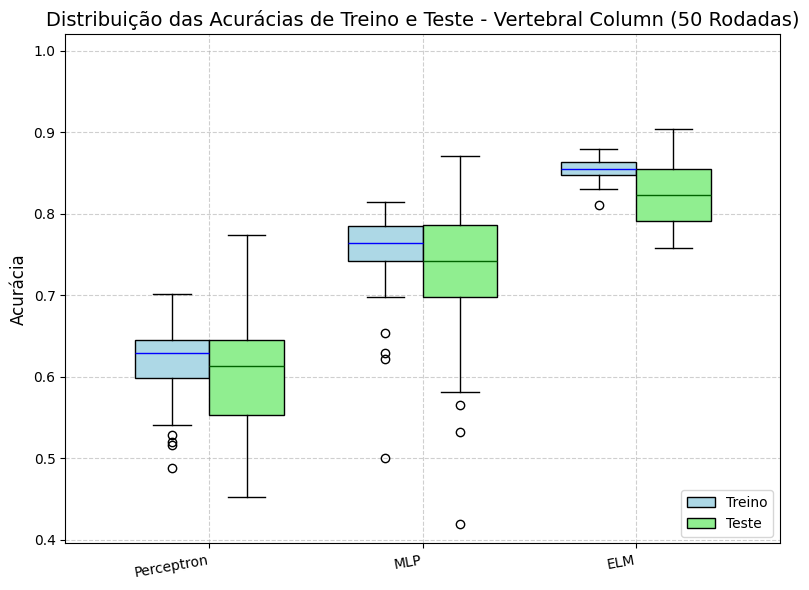

In [26]:
plot_accuracy_boxplots(results_vc, "Vertebral Column")

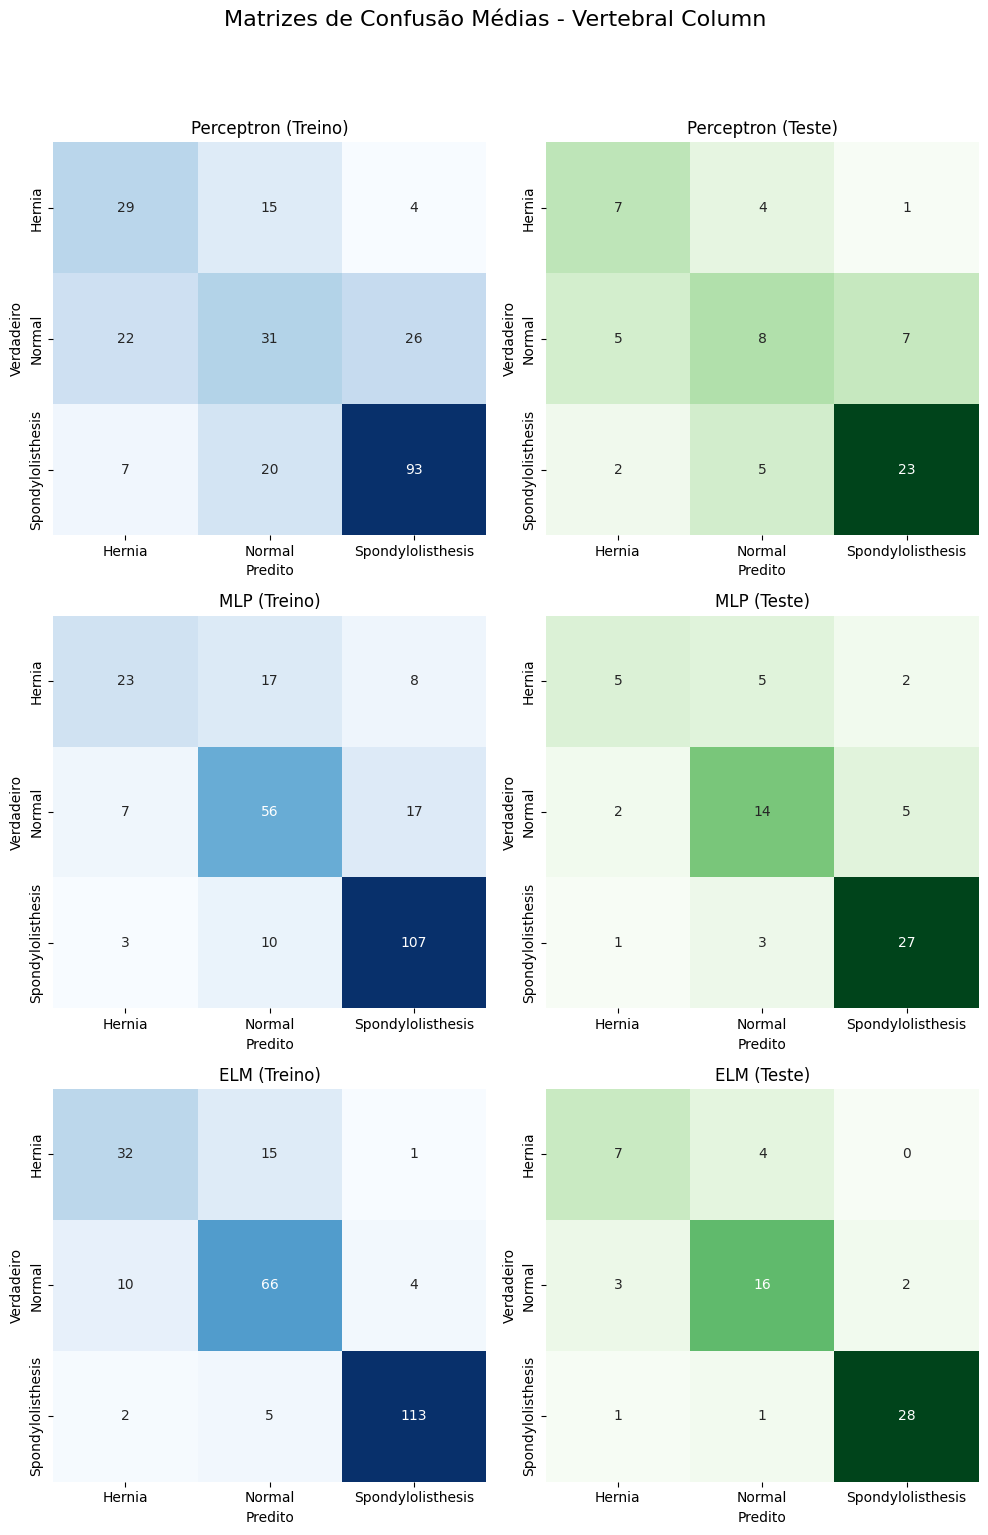

In [27]:
plot_confusion_matrices(conf_matrices_vc, labels_vc, "Vertebral Column")